In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
# Blanchard Kahn solution
class ReturnBK(object):
    def __init__(self, H, R, F, Q, condition):
        self.H = H
        self.R = R
        self.F = F
        self.Q = Q
        self.condition = condition

def BlanchardKahn(A0,A1,B,n,m):
    # Finds solution to the following model: A0 y[t+1] = A1 y[t] + B e[t+1]
    # n: number of predetermined variables
    # m: number of non-predetermined (or forward-looking) variables
    
    invA0 = np.linalg.inv(A0)
    A = np.dot(invA0,A1)
    
    Lambda,P = np.linalg.eig(A)
    if sum(np.abs(Lambda)>1)==m:

        try:
            idx=np.abs(Lambda).argsort()

            Lambda = np.diag(Lambda[idx])
            P = P[:,idx]

            invP = np.linalg.inv(P)

            Pstar11 = np.real(invP[:n,:n])
            Pstar12 = np.real(invP[:n,n:])
            Pstar21 = np.real(invP[n:,:n])
            Pstar22 = np.real(invP[n:,n:])

            invPstar22 = np.linalg.inv(Pstar22)
            invPstarss = np.linalg.inv(Pstar11 - np.dot(np.dot(Pstar12,invPstar22),Pstar21))


            Lambda1 = np.real(Lambda[:n,:n])
            Lambda2 = np.real(Lambda[n:,n:])

            Q = np.dot(np.dot(invP,invA0),B)
            Q1 = np.real(Q[:n,:n])
            Q2 = np.real(Q[n:,n:])

            H_bk = -np.dot(invPstar22,Pstar21)
            R_bk = np.zeros(shape=(H_bk.shape[0],H_bk.shape[0]))
            F_bk = np.dot(np.dot(invPstarss,Lambda1),Pstar11 - np.dot(np.dot(Pstar12,invPstar22),Pstar21))
            Q_bk = np.dot(invPstarss,Q1)

            # Final results
            H = np.concatenate((np.identity(m),np.zeros((m,n))),axis=1)
            R = np.zeros((m,m))
            F = np.concatenate((np.zeros((m+n,m)),np.concatenate((np.dot(H_bk,F_bk),F_bk),axis=0)),axis=1)
            Q = np.diagflat(np.sqrt(np.abs(np.concatenate((np.dot(H_bk,Q_bk),Q_bk),axis=0))))

            condition = 'BK condition attended'
        except Exception: # P not inversible
            H=np.nan
            R=np.nan
            F=np.nan
            Q=np.nan
            condition = 'P not inversible'

    else: # Blanchard Kahn condition not attended
        H=np.nan
        R=np.nan
        F=np.nan
        Q=np.nan
        condition = 'BK condition not attended'
    
    return ReturnBK(H, R, F, Q, condition)

In [3]:
# Kalman filter
class ReturnKF(object):
    def __init__(self, yHat, aMinus, VMinus, L):
        self.yHat = yHat
        self.aMinus = aMinus
        self.VMinus = VMinus
        self.L = L

def KalmanFilter(H, R, F, Q, y, forecast):
    # Useful variables and matrices
    m = H.shape[1]
    p = H.shape[0]
    T = y.shape[0] + forecast
    
    yHat   = np.zeros((T  ,p))
    yFull  = np.concatenate((np.array(y),np.nan*np.zeros((forecast,p))),axis=0)
    
    nu     = np.zeros((T  ,p))
    a      = np.zeros((T  ,m))
    aMinus = np.zeros((T+1,m))
    
    S      = np.zeros((T  ,p,p))
    V      = np.zeros((T  ,m,m))
    VMinus = np.array([np.identity(m) for t in range(T+1)])
    K      = np.zeros((T  ,m,p))
    
    Ht     = np.transpose(H)
    Ft     = np.transpose(F)
    
    # Recursevely calculates the Kalman filter
    try:
        for t in range(T):
            # Filtered values
            yHat[t] = np.dot(H,aMinus[t])

            for i in range(p):
                if np.isnan(yFull[t][i]):
                    yFull[t][i] = yHat[t][i]

            # Update equations    
            nu[t] = yFull[t] - np.dot(H,aMinus[t])
            S[t]  = np.dot(np.dot(H,VMinus[t]),Ht) + R
            K[t]  = np.dot(np.dot(VMinus[t],Ht),np.linalg.inv(S[t]))
            a[t]  = aMinus[t] + np.dot(K[t],nu[t])
            V[t]  = np.dot((np.identity(m)-np.dot(K[t],H)),VMinus[t])

            # Forecast equations
            aMinus[t+1] = np.dot(F,a[t])
            VMinus[t+1] = np.dot(np.dot(F,V[t]),Ft) + Q

        # Calculates likelihood
        L=0.0
        for t in range(T):
            L = L + np.log(np.linalg.det(S[t])) + np.dot(np.dot(np.transpose(nu[t]),np.linalg.inv(S[t])),nu[t])

        L = -T*p/2* np.log(2*np.pi) - 1/2 * L
        
    except Exception:
        yHat   = np.nan
        aMinus = np.nan
        VMinus = np.nan
        L      = -np.inf
        
    return ReturnKF(yHat, aMinus, VMinus, L)

## Model
#### Dynamic IS:
$$ x_t = E_tx_{t+1}-\frac{1}{\sigma}(i_t-E_t\pi_{t+1}) $$

Where:

$x_t \equiv$ output gap at instant $t$

$i_t \equiv$ nominal interest rate at instant $t$

$\pi_t \equiv$ inflation rate at instant $t$

And the parameters are:

$\sigma \equiv$ intertemporal elasticity of substitution in consumption


#### Phillips curve:
$$ \pi_t = \beta E_t\pi_{t+1} - \kappa x_t $$

Where:

$\kappa \equiv \frac{(1-\omega)(1-\beta\omega)}{(\alpha\omega)}$

And the parameters are:

$\beta \equiv$ discount rate

$\omega \equiv$ proportion of firms not changing prices

$\alpha^{-1} \equiv$ elasticity of wages with respect to output gap

#### Monetary policy rule:
$$ i_t = \varphi_\pi \pi_t + \nu_t $$
$$ \nu_{t+1} = \rho \nu_t + v\varepsilon_{t+1}$$

Where:

$\varepsilon_t \sim N(0,1)$

---
In matrix notation:

$$
\left[\begin{matrix}
1 & 0 & 0 \\
0 & 1 & \frac{1}{\sigma} \\
0 & 0 & \beta
\end{matrix}\right]
\left[\begin{matrix}
\nu_{t+1} \\
E_tx_{t+1} \\
E_t\pi_{t+1}
\end{matrix}\right]
=
\left[\begin{matrix}
\rho & 0 & 0 \\
\frac{1}{\sigma} & 1 & \frac{\varphi_\pi}{\sigma} \\
0 & -\kappa & 1
\end{matrix}\right]
\left[\begin{matrix}
\nu_t \\
x_t \\
\pi_t
\end{matrix}\right]
+
\left[\begin{matrix}
v \\
0 \\
0
\end{matrix}\right]
\varepsilon_{t+1}
$$

$$\Leftrightarrow$$

$$ A_0
\left[\begin{matrix}
\omega_{t+1} \\
E_ty_{t+1}
\end{matrix}\right]
=
A_1
\left[\begin{matrix}
\omega_t \\
y_t
\end{matrix}\right]
+B\varepsilon_{t+1}
$$

Where $\omega_t$ is the $(n \times 1)$ vector that represents *predetermined variables*, and $y_t$ the $(m \times 1)$ vector that represents *forward-looking control variables*. In our case, $n=1$ and $m=2$.

In [4]:
# Model
class ReturnModel(object):
    def __init__(self, A0, A1, B):
        self.A0 = A0
        self.A1 = A1
        self.B = B

def modelator(sigma,beta,rho,phi_pi,v,omega,alpha):
    kappa = (1-omega)*(1-beta*omega)/(alpha*omega)
    A0 = np.array([[1,0,       0],
                   [0,1, 1/sigma],
                   [0,0,    beta]])
    A1 = np.array([[    rho,     0,           0],
                   [1/sigma,     1,phi_pi/sigma],
                   [      0,-kappa,           1]])
    B = np.array([[v],
                  [0],
                  [0]])
    
    return ReturnModel(A0, A1, B)

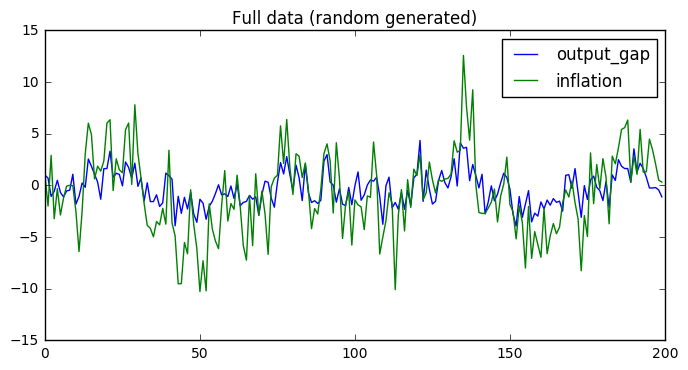

In [5]:
# Generates some random data

# Value of "true" parameters ...
sigma = 1.0   # intertemporal elasticity of substitution in consumption
beta = 0.99   # discount rate
rho = 0.75     # coefficient of AR in monetary policy shock
phi_pi = 1.5  # coefficient of inflation in monetary policy rule
v = 1         # std deviation of monetary policy shock
omega = 0.5   # proportion of firms not changing prices
alpha = 3.0   # 1/alpha is elasticity of wages with respect to output gap

kappa = (1-omega)*(1-beta*omega)/(alpha*omega)

# ... in BK matrices
A0 = np.array([[1,0,       0],
               [0,1, 1/sigma],
               [0,0,    beta]])

A1 = np.array([[    rho,     0,           0],
               [1/sigma,     1,phi_pi/sigma],
               [      0,-kappa,           1]])

B = np.array([[v],
              [0],
              [0]])

# ...in KF matrices
BK = BlanchardKahn(A0,A1,B,1,2)

# generates output gap and inflation consistent with the model
T = 200
m = BK.H.shape[1]
p = BK.H.shape[0]

y = np.array([[1.0 for i in range(p)] for t in range(T)])
x = np.array([[1.0 for i in range(m)] for t in range(T)])
    
for t in range(T):
    if p==1:
        if BK.R==0:
            y[t] = np.dot(BK.H,x[t])
        else:
            y[t] = y[t] + np.random.normal(0,BK.R)
    else:
        if np.all(BK.R==np.zeros(shape=(p,p))):
            y[t] = np.dot(BK.H,x[t])
        else:
            y[t] = np.dot(BK.H,x[t]) + np.random.multivariate_normal(np.zeros(p),BK.R)
        
    if t+1<T:
        if m==1:
            if BK.Q==0:
                x[t+1] = np.dot(BK.F,x[t])
            else:
                x[t+1] = np.dot(BK.F,x[t]) + np.random.normal(0,BK.Q)
        else:
            if np.all(BK.Q==np.zeros(shape=(m,m))):
                x[t+1] = np.dot(BK.F,x[t])
            else:
                x[t+1] = np.dot(BK.F,x[t]) + np.random.multivariate_normal(np.zeros(m),BK.Q)

completeData = pd.DataFrame(y,columns=['output_gap','inflation'])
                
# Plot
figComplete = plt.figure(figsize=(8,4))
axComplete = figComplete.add_subplot(111)
axComplete.plot(completeData.index, completeData);

# Cleanup
axComplete.legend([label for label in completeData.columns],loc='best')
axComplete.set_title('Full data (random generated)');

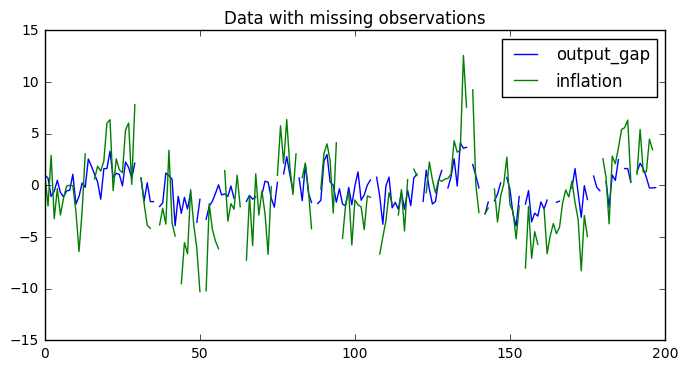

In [6]:
# Drop some data points...
missingData = pd.DataFrame(completeData)
probMiss = 0.1
for t in missingData.index:
    for i in missingData.columns:
        if np.random.rand()<probMiss:
            missingData.loc[t,i]=np.nan
# ... and some data rows
probMiss = 0.1
for t in missingData.index:
    if np.random.rand()<probMiss:
        missingData.loc[t,:]=np.nan

# Plot
figMissing = plt.figure(figsize=(8,4))
axMissing = figMissing.add_subplot(111)
axMissing.plot(missingData.index, missingData);

# Cleanup
axMissing.legend([label for label in missingData.columns],loc='best')
axMissing.set_title('Data with missing observations');


In [7]:
#%%timeit
#BK = BlanchardKahn(A0,A1,B,1,2)
#KF = KalmanFilter(BK.H, BK.R, BK.F, BK.Q, missingData, 10)

In [8]:
### Metropolis hastings initialization

# set model fixed parameters
sigma = 1.0
beta = 0.99
rho = 0.75
# phi_pi = 1.5
v = 1
omega = 0.5
# alpha = 3.0

# Set priors PDFs
def phiPrior(x):
    return stats.chi2.pdf((x-1), 3)
def alphaPrior(x):
    return stats.chi2.pdf((x-1), 3)

In [9]:
### Finds maximum likelihood estimate and hessian matrix
# Memo: minimize -logL
def objectiveFunction(theta):
    
    model = modelator(sigma,beta,rho,theta[0],v,omega,theta[1])
    try:
        BK = BlanchardKahn(model.A0,model.A1,model.B,1,2)
        if BK.condition=='BK condition attended':
            logL = KalmanFilter(BK.H, BK.R, BK.F, BK.Q, completeData, 0).L
            return -logL
        else:

            return np.inf
    except Exception:
        return np.inf
    
theta0 = np.array([1.6,2.1])
MLE = minimize(objectiveFunction,x0=theta0,method='BFGS',options={'maxiter':10000}) # Nelder-Mead
print(MLE.message)
print('')
MLE

Desired error not necessarily achieved due to precision loss.



      fun: 799.75632874359212
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ inf,  inf])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 36
      nit: 0
     njev: 6
   status: 2
  success: False
        x: array([ 1.6,  2.1])

In [10]:
# Set MH parameters
n = 10000
start = np.array([[1.6,2.9]])
#burn_in = .1
theta=start
k = np.identity(theta.shape[1])*0.1
    
sample = pd.DataFrame(columns=['phi_pi','alpha'],index=range(n))
sample.loc[0,:] = theta

# Calculates initial iteration
model = modelator(sigma,beta,rho,theta[0,0],v,omega,theta[0,1])

BK = BlanchardKahn(model.A0,model.A1,model.B,1,2)
if BK.condition!='BK condition attended':
    print("Bad initial theta")
else:
    logL = KalmanFilter(BK.H, BK.R, BK.F, BK.Q, completeData, 0).L
    count = 1
    i=1
    
    print('Simulating...')
    print('0%       |10%      |20%      |30%      |40%      |50%      |60%      |70%      |80%      |90%      |100%')
    
    while(i<n):
        
        ## MH loops
        # Draw q(theta1 | theta0)
        # transform to continuous domain
        theta[0,0] = np.log(theta[0,0]-1)
        theta[0,1] = np.log(theta[0,1]-1)

        # Draw random step
        newTheta = theta + np.random.multivariate_normal(np.zeros(theta.shape[1]),k)

        # Transform theta back
        theta[0,0] = np.exp(theta[0,0])+1
        theta[0,1] = np.exp(theta[0,1])+1

        newTheta[0,0] = np.exp(newTheta[0,0])+1
        newTheta[0,1] = np.exp(newTheta[0,1])+1

        # Solves BK
        model = modelator(sigma,beta,rho,newTheta[0,0],v,omega,newTheta[0,1])
        BK = BlanchardKahn(model.A0,model.A1,model.B,1,2)

        if BK.condition=='BK condition attended':
            try:
                KF = KalmanFilter(BK.H, BK.R, BK.F, BK.Q, missingData, 0)
                count = count+1

                # Compute alpha
                posterior = logL + np.log(phiPrior(theta[0,0])) + np.log(alphaPrior(theta[0,1]))
                newPosterior = KF.L + np.log(phiPrior(newTheta[0,0])) + np.log(alphaPrior(newTheta[0,1]))

                acceptanceRatio = np.exp(newPosterior - posterior)

                # Compute r = min(1,alpha)
                r = min(1,acceptanceRatio)

                # Accept or reject new theta
                u = np.random.uniform(0,1)

                if u<r:
                    theta = newTheta
                    sample.loc[i,:] = theta
                    logL = KF.L
                    i = i+1
                    if int(i*100/n)==i*100/n: print('#',end='')
            except Exception:
                pass
            

    #sample = sample[int(-(1-burn_in)*n):]
    print('')
    print('Acceptance ratio: '+'{0:.2%}'.format(i/count))

Simulating...
0%       |10%      |20%      |30%      |40%      |50%      |60%      |70%      |80%      |90%      |100%
####################################################################################################
Acceptance ratio: 0.91%


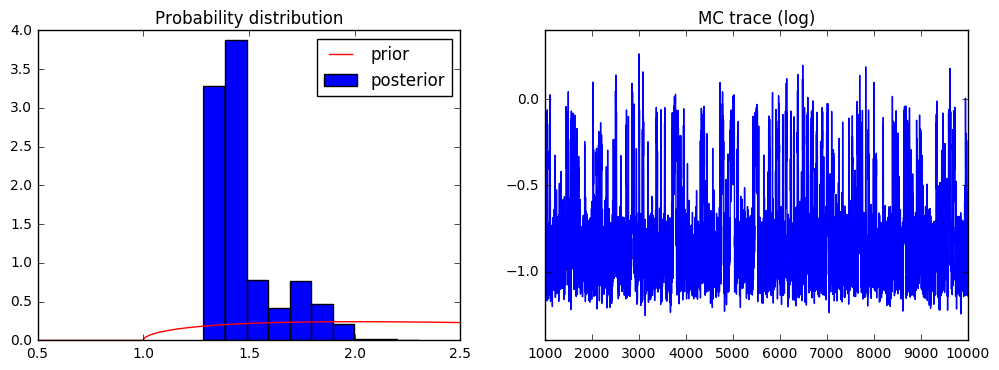

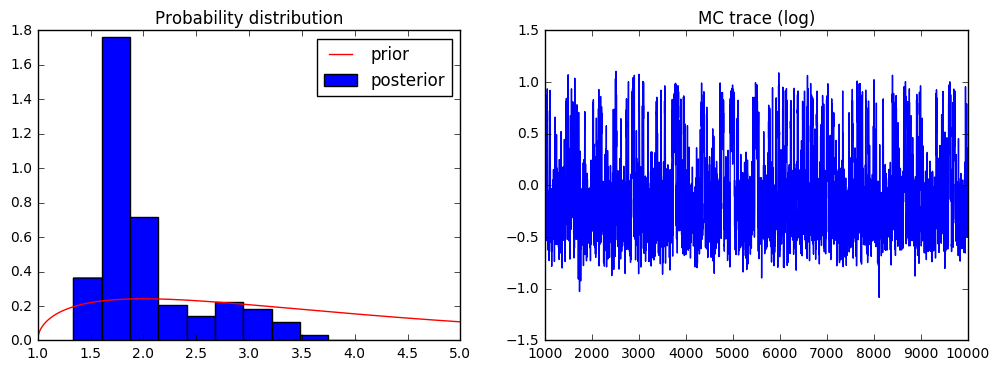

In [12]:
# Plot
burn_in =  .1

## Plot MCMC sample: phi_pi
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)

ax1.hist(sample['phi_pi'][int(-(1-burn_in)*n):], normed=True)

X = np.linspace(0.5,2.5, 1000)
ax1.plot(X, phiPrior(X), 'r')
ax1.set_title('Probability distribution')
ax1.legend(['prior','posterior'],loc='best')
plt.xlim(0.5,2.5)

ax2 = fig.add_subplot(122)
ax2.set_title('MC trace (log)')
ax2.plot(sample['phi_pi'][int(-(1-burn_in)*n):].apply(lambda x: np.log(x-1)));



## Plot MCMC sample: alpha
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)

ax1.hist(sample['alpha'][int(-(1-burn_in)*n):], normed=True)

X = np.linspace(1.0,5, 1000)
ax1.plot(X, alphaPrior(X), 'r')
ax1.set_title('Probability distribution')
ax1.legend(['prior','posterior'],loc='best')
plt.xlim(1.0,5.0)

ax2 = fig.add_subplot(122)
ax2.set_title('MC trace (log)')
ax2.plot(sample['alpha'][int(-(1-burn_in)*n):].apply(lambda x: np.log(x-1)));